In [1]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import time
import copy
import cv2
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Colab_Notebooks/DL/Project/deep_learning_project/

/content/drive/MyDrive/Colab_Notebooks/DL/Project/deep_learning_project


In [51]:
df = pd.read_csv("Data/features_30_sec.csv")
df = df[['filename','label']]

In [52]:
df = df[df['filename'] != "jazz.00054.wav"]

In [53]:
df = df.reset_index()

In [54]:
df.pop('index')

0        0
1        1
2        2
3        3
4        4
      ... 
994    995
995    996
996    997
997    998
998    999
Name: index, Length: 999, dtype: int64

In [55]:
class_name = {}
n = 0
for i in set(df['label']):
    class_name[i] = n
    n+=1
num_classes = n

In [56]:
df['label'] = df['label'].map(class_name)
for i in range(len(df)):
    temp = df['filename'][i].split(".")
    df['filename'][i] = "Data/images_original/" + temp[0] + "/" + temp[0] + temp[1] + ".png"

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [57]:
train, test = train_test_split(df, test_size=0.20, random_state=42, stratify = df['label'])
test, val = train_test_split(test, test_size=0.50, random_state=42, stratify = test['label'])

In [58]:
dataset_sizes = {'train': len(train), 'test': len(test), 'val': len(val)}
print(dataset_sizes)

{'train': 799, 'test': 100, 'val': 100}


In [59]:
class GenreDataset(Dataset):
    """Genre dataset."""

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv = csv_file
        self.transform = transform

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.csv.iloc[idx, 0]
        image = cv2.imread(img_name,cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = np.expand_dims(image, axis=-1)
        details = self.csv.iloc[idx, 1:]
        sample = {'image': image, 'label': details[0]}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [60]:
class PreProcessing(object):

    def __init__(self):
        pass

    def __call__(self, sample):
        image, turtle_id = sample['image'], sample['label']
        h, w = image.shape[:2]
        
        ### ADD PREPROCESSING CODE HERE
        
        return [torch.Tensor(image.transpose(2,0,1)), turtle_id]

In [61]:
train_transformed_dataset = GenreDataset(csv_file=train,
                                               transform=transforms.Compose([
                                               PreProcessing()
                                           ]))
test_transformed_dataset = GenreDataset(csv_file=test,
                                               transform=transforms.Compose([
                                               PreProcessing()
                                           ]))
val_transformed_dataset = GenreDataset(csv_file=val,
                                               transform=transforms.Compose([
                                               PreProcessing()
                                           ]))

In [62]:
dataloaders = {'train' : DataLoader(train_transformed_dataset, batch_size=16,
                        shuffle=True, num_workers=0),
              'test' : DataLoader(test_transformed_dataset, batch_size=8,
                        shuffle=True, num_workers=0),
              'val' : DataLoader(val_transformed_dataset, batch_size=16,
                        shuffle=True, num_workers=0)}

In [63]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Training Code - Normal

In [64]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    losses = {'train':[], 'val':[]}
    accuracies = {'train':[], 'val':[]}
    every_n_epoch = 5

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # inputs = inputs.type(torch.DoubleTensor)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs.float())
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if epoch%every_n_epoch == 0:
              losses[phase] += [epoch_loss]
              accuracies[phase] += [epoch_acc.cpu().detach().numpy()]

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, losses, accuracies

# Train code with Early Stopping

In [65]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    losses = {'train':[], 'val':[]}
    accuracies = {'train':[], 'val':[]}
    every_n_epoch = 5

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    stop_trigger = 0
    patience = 5

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate model

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # inputs = inputs.type(torch.DoubleTensor)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs.float())
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            current_epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # if (current_epoch_acc >= max_val_acc):
            #   max_val_acc = current_epoch_acc
            #   stop_trigger = 0 # Reset count
            
            # elif (current_epoch_acc < max_val_acc):
            #   stop_trigger += 1 
            #   print("Triggered! --> ", stop_trigger , "/", patience)

            # if stop_trigger == patience:
            #     print("Early stopped!!!")
            #     break
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, current_epoch_acc))
            # print("Max Validation Accuracy: ", max_val_acc)

            if epoch%every_n_epoch == 0:
              losses[phase] += [epoch_loss]
              accuracies[phase] += [current_epoch_acc.cpu().detach().numpy()]

            # deep copy the model
            if phase == 'val' and current_epoch_acc >= best_acc:
              best_acc = current_epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())
              stop_trigger = 0 # Reset count

            elif phase == 'val' and current_epoch_acc < best_acc:
              stop_trigger += 1
              print(current_epoch_acc, best_acc)
              print("Triggered! --> ", stop_trigger , "/", patience)
            
        if stop_trigger == patience:
          print("Early Stopped!!!")
          break

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, losses, accuracies

### Need to define our model below

In [66]:

import torch
import torch.nn as nn

def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(1, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        # self.fc = nn.Linear(64, num_classes)
        self.fc = nn.Linear(4480, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        # print(out)
        return out

In [67]:
# model = CNN()
model = ResNet(ResidualBlock, [2, 2, 2]).to(device)
print("# of trainable parameters:",sum(p.numel() for p in model.parameters() if p.requires_grad))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) 
# optimizer = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# of trainable parameters: 239610


In [68]:
torch.cuda.empty_cache() 

In [69]:
model = model.to(device)

In [70]:
model, losses, accuracies = train_model(model, criterion, optimizer, exp_lr_scheduler,100)

Epoch 0/99
----------
train Loss: 2.2181 Acc: 0.2103
val Loss: 1.8781 Acc: 0.3100

Epoch 1/99
----------
train Loss: 1.6886 Acc: 0.4093
val Loss: 1.6362 Acc: 0.3500

Epoch 2/99
----------
train Loss: 1.4880 Acc: 0.4731
val Loss: 1.3110 Acc: 0.4700

Epoch 3/99
----------
train Loss: 1.2976 Acc: 0.5482
val Loss: 1.1806 Acc: 0.6200

Epoch 4/99
----------
train Loss: 1.1792 Acc: 0.6070
val Loss: 1.1826 Acc: 0.5300
tensor(0.5300, device='cuda:0', dtype=torch.float64) tensor(0.6200, device='cuda:0', dtype=torch.float64)
Triggered! -->  1 / 5

Epoch 5/99
----------
train Loss: 0.9531 Acc: 0.6783
val Loss: 1.1333 Acc: 0.6200

Epoch 6/99
----------
train Loss: 0.8412 Acc: 0.7109
val Loss: 1.5036 Acc: 0.5300
tensor(0.5300, device='cuda:0', dtype=torch.float64) tensor(0.6200, device='cuda:0', dtype=torch.float64)
Triggered! -->  1 / 5

Epoch 7/99
----------
train Loss: 0.6243 Acc: 0.8210
val Loss: 0.9163 Acc: 0.7100

Epoch 8/99
----------
train Loss: 0.5526 Acc: 0.8398
val Loss: 0.8858 Acc: 0.740

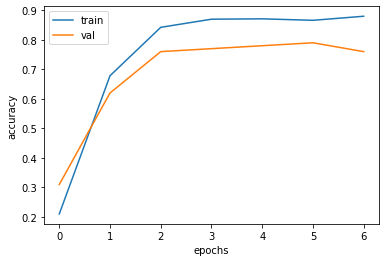

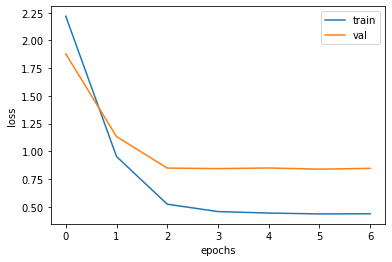

In [71]:
def plot_performance(metric, values):
  plt.plot(values['train'])
  plt.plot(values['val'])
  plt.xlabel("epochs")
  plt.ylabel(metric)
  plt.legend(values.keys())
  plt.show()

plot_performance('accuracy', accuracies)
plot_performance('loss', losses)

In [72]:
torch.save(model.state_dict(),"weights_earlystopping3.pth")

In [73]:
def test_model(model, criterion):

    model.eval()   # Set model to evaluate mode

    t_output = []
    t_pred = []
    y_test = []
    top_k = []
    # Iterate over data.
    i = 1
    for inputs, labels in dataloaders['test']:
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        y_test.append(labels)

        # forward
        # track history if only in train
        with torch.no_grad():
            outputs = model(inputs.float())
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            t_output.append(outputs)
            t_pred.append(preds)
            temp1, temp2 = outputs.topk(5)
            top_k.append(temp2)

    y_test = torch.cat(y_test).cpu().detach().numpy() 
    y_test_num = torch.cat(t_pred).cpu().detach().numpy() 
    y_pred = torch.cat(top_k).cpu().detach().numpy() 

    print('\nConfusion Matrix')
    conf_mt = confusion_matrix(y_test_num, y_test)
    print(conf_mt)
    plt.matshow(conf_mt)
    plt.show()
    print('\nClassification Report')
    print(classification_report(y_test_num, y_test, zero_division=0))

In [74]:
torch.cuda.empty_cache() 


Confusion Matrix
[[ 8  2  0  0  1  1  0  0  0  0]
 [ 1  6  1  0  1  0  0  0  0  0]
 [ 0  0  4  0  1  0  0  0  0  0]
 [ 1  0  2  7  0  1  1  0  0  0]
 [ 0  1  2  1  5  1  1  0  1  0]
 [ 0  0  0  0  0  6  0  0  0  0]
 [ 0  1  0  2  1  0  7  0  0  0]
 [ 0  0  1  0  0  0  1 10  0  0]
 [ 0  0  0  0  0  1  0  0  9  1]
 [ 0  0  0  0  1  0  0  0  0  9]]


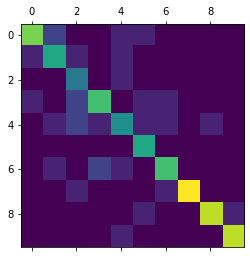


Classification Report
              precision    recall  f1-score   support

           0       0.80      0.67      0.73        12
           1       0.60      0.67      0.63         9
           2       0.40      0.80      0.53         5
           3       0.70      0.58      0.64        12
           4       0.50      0.42      0.45        12
           5       0.60      1.00      0.75         6
           6       0.70      0.64      0.67        11
           7       1.00      0.83      0.91        12
           8       0.90      0.82      0.86        11
           9       0.90      0.90      0.90        10

    accuracy                           0.71       100
   macro avg       0.71      0.73      0.71       100
weighted avg       0.74      0.71      0.71       100



In [75]:
test_model(model, criterion)